In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

import sklearn
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

## Load training data

In [2]:
directory = 'data/preprocessed/'

In [3]:
mfccs = np.load(directory + 'mfccs.npy')
str_labels = np.load(directory + 'str_labels.npy')


In [4]:
print(mfccs.shape)

(760, 12, 672)


In [5]:
print(pd.DataFrame(str_labels).value_counts())

neutral    380
stress     380
dtype: int64


In [6]:
mfccs = np.expand_dims(mfccs, axis = -1)

In [7]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(str_labels)
labels = le.transform(str_labels)

In [8]:
print(pd.DataFrame(str_labels).value_counts())

neutral    380
stress     380
dtype: int64


In [9]:
mfccs.shape

(760, 12, 672, 1)

## Create train/test splits

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(mfccs, labels, test_size=0.3, random_state=42, stratify = labels)

## Normalize the MFCCs

In [11]:
scaler = sklearn.preprocessing.StandardScaler()
X_train_tp = X_train.transpose(0,2,1,3)
X_test_tp = X_test.transpose(0,2,1,3)
X_train_scaled = scaler.fit_transform(X_train_tp.reshape(-1, 12)).reshape(X_train_tp.shape).transpose(0,2,1,3)
X_test_scaled = scaler.transform(X_test_tp.reshape(-1, 12)).reshape(X_test_tp.shape).transpose(0,2,1,3)

In [12]:
print(X_train_tp.shape)

(532, 672, 12, 1)


In [13]:
X_train_scaled.shape

(532, 12, 672, 1)

In [14]:
(y_train==0).sum()

266

In [15]:
(y_train==1).sum()

266

In [16]:
(y_test==0).sum()

114

In [17]:
(y_test==1).sum()

114

## Define and train model

In [18]:
model = keras.models.Sequential([keras.layers.Normalization(axis = 1, mean = scaler.mean_, variance = scaler.var_),
                                 keras.layers.Conv1D(1, 5, activation="relu", input_shape = mfccs.shape[1:],  kernel_regularizer=regularizers.l2(0.001)),
                                 keras.layers.MaxPooling2D(pool_size= (1,15), strides=(1,15), padding='same'), 

                                 #keras.layers.Conv1D(1, 3, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
                                 #keras.layers.MaxPooling2D(pool_size=(1, 3), strides=(1, 3), padding = 'same'),

                                 keras.layers.Flatten(),

                                 #keras.layers.Dense(3, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid",  kernel_regularizer=regularizers.l2(0.001)),
])

model.compile(loss = "binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3), metrics = ["accuracy"])

In [19]:
history = model.fit(X_train, y_train, batch_size = 4, epochs = 5, validation_data=(X_test, y_test))

Epoch 1/5
133/133 [==============================] - 3s 13ms/step - loss: 0.4541 - accuracy: 0.8083 - val_loss: 0.2878 - val_accuracy: 0.9035
Epoch 2/5
133/133 [==============================] - 1s 6ms/step - loss: 0.2006 - accuracy: 0.9380 - val_loss: 0.2061 - val_accuracy: 0.9342
Epoch 3/5
133/133 [==============================] - 1s 5ms/step - loss: 0.1339 - accuracy: 0.9568 - val_loss: 0.1424 - val_accuracy: 0.9518
Epoch 4/5
133/133 [==============================] - 1s 6ms/step - loss: 0.0947 - accuracy: 0.9718 - val_loss: 0.1089 - val_accuracy: 0.9561
Epoch 5/5
133/133 [==============================] - 1s 9ms/step - loss: 0.0724 - accuracy: 0.9793 - val_loss: 0.0957 - val_accuracy: 0.9605


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (4, 12, 672, 1)          0         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (4, 12, 668, 1)           6         
                                                                 
 max_pooling2d (MaxPooling2D  (4, 12, 45, 1)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (4, 540)                  0         
                                                                 
 dense (Dense)               (4, 1)                    541       
                                                                 
Total params: 547
Trainable params: 547
Non-trainable pa

## Save model and evaluate

In [21]:
model.save('models/model')

INFO:tensorflow:Assets written to: models/model\assets


In [22]:
model = keras.models.load_model('models/model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12, 672, 1)       0         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 12, 668, 1)        6         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 45, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 1)                 541       
                                                                 
Total params: 547
Trainable params: 547
Non-trainable pa

In [23]:
probabilities = model.predict(X_test)
y_pred = probabilities.round()
sklearn.metrics.f1_score(y_test, y_pred, average='weighted')

0.9604647130223686

In [24]:
probabilities.shape

(228, 1)

<AxesSubplot:>

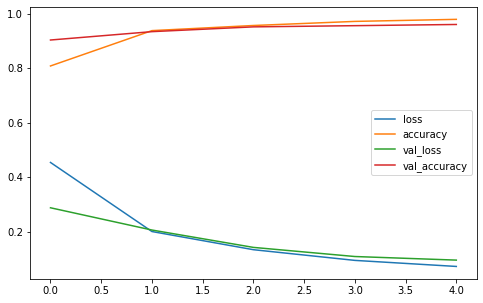

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))

<AxesSubplot:>

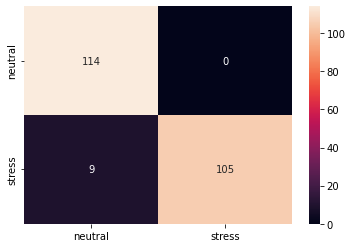

In [26]:
# Finally make the confusion matrix
index_labels = le.classes_
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_pred, labels=[0,1]), annot=True, fmt='g', xticklabels=index_labels, yticklabels=index_labels)

## Save the best model

In [27]:
#model.save("models/best_model")

In [28]:
model = keras.models.load_model('models/best_model')

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 12, 672, 1)       0         
 ion)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 668, 1)        6         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 45, 1)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 540)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 541       
                                                                 
Total params: 547
Trainable params: 547
Non-trainable 